# HRV Parameter Extraction
This notebook is used for analysing significance of patient HRV parameters extracted in part 4. 

To do:
- Connect HRV parameters with patient parameters
- Apply Mann-Whitney tests to parameters (done)
- Initial overview of parameters (includes plotting parameters against each other in 2D, 3D, PCA, compare with values from other databases, how much correlation can be attributed to other factors e.g. age, years from diagnosis, etc.)
- (optional) restructure the db to be multiindexed??
- Test classification algorithms to set a range for CAN vs control patients...

## Initial setup

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pyarrow.feather as feather
from tqdm import tqdm
from scipy.stats import mannwhitneyu

In [3]:
root = 'G:\My Drive\Molecool\Databases\Database1'
#root = '/Volumes/GoogleDrive/.shortcut-targets-by-id/1sZgDE1M3o-bDINfAQYEXl_vqsKs03WxD/Molecool/Databases/Database1'

## Functions

In [4]:
def check_clean_valid(path):
    """Only indicates that the folder is valid if it contains a file named 'CleanParameters.json'
    Input: Filepath
    Output: True if the folder indexed by the filepath contains a file called CleanParameters.json, False otherwise"""
    return os.path.exists(path + '/CleanParameters.json')

In [5]:
def collect_row(parapath, patient, count):
    """Extracts information about the snippet from the snippet metadata file and inputs, and returns a dictionary ready to be added as a row in a DataFrame
    Input: snippet folder path, patient ID, number of the snippet for this patient
    Output: Dictionary with information about snippet"""
    with open(parapath + '/CleanParameters.json') as json_file:
        row = json.load(json_file)
        json_file.close()
        
    row['Patient'] = patient
    row['Count'] = count[-3:]
    print(row)
    return row

In [6]:
def lookup_patient(paradf, root):
    """Adds patient classifications (diabetic vs control, CAD vs no CAD) by...
    ...looking up values in the small metadata file (sdf) associated with the...
    ..database and editing the parameter dataframe accordingly
    Input: DataFrame of Parameters (paradf), root of the database (root)
    Output: Edited paradf"""
    # Load the Small Metadata file
    #with open(root + '\\SMeta.json') as json_file:
    with open(root + '/SMeta.json') as json_file:
        sdf = pd.read_json(json_file, orient = 'index')
        json_file.close()
    
    # Add DM/C classification
    paradf['CAD'] = (sdf.loc[paradf['Patient']]['CAN Symptoms']).reset_index(drop=True)
    
    # Add CAN/Not classification
    paradf['Diabetic'] = (sdf.loc[paradf['Patient']]['Diabetic']).reset_index(drop=True)
    
    return paradf

## Initial Analysis of clean HRV Snippet Parameters
### Load All parameters and classification into DF

In [7]:
rows = []

patients = sorted(os.listdir(root))
for pat in tqdm(patients):     #Looping throught the folder Sxxxx
    if not pat.endswith(('.json', 'ini','\r')):
        path_pat = root+'/'+pat
        folders = sorted(os.listdir(path_pat))
        for folder in folders:    #Looping through the different ecg types 
            if not folder.endswith('.ini') and folder != 'Icon\r':
                path_folder = path_pat + '/' +folder   
                snippets = sorted(os.listdir(path_folder))
                for snip_folder in snippets:  #Looping through the snippet folders
                    if not snip_folder.endswith(('.json', '.ftr', '.ini','\r')):
                        print("In snippet folder " + snip_folder)
                        
                        ### NOW IN CORRECT FOLDER ###
                        path_snip =path_folder + '/' + snip_folder
                        if check_clean_valid(path_snip):
                            rows.append(collect_row(path_snip, pat, snip_folder))
                            print('\n\n')

  0%|                                                                                           | 0/56 [00:00<?, ?it/s]

In snippet folder Snippet000
In snippet folder Snippet001


  4%|██▉                                                                                | 2/56 [00:02<01:08,  1.27s/it]

{'SDNN': 9.388711176710585, 'RMSSD': 3.7275644651843733, 'PNN50': 0.0, 'LF': 6.972244720053225, 'HF': 5.05258479487378, 'LFHF': 1.3799362114866596, 'Patient': 'S0250', 'Count': '001'}



In snippet folder Snippet002
In snippet folder Snippet000
In snippet folder Snippet000
{'SDNN': 19.93502977681763, 'RMSSD': 11.883778830332387, 'PNN50': 0.0, 'LF': 13.341491259583142, 'HF': 19.309388679624874, 'LFHF': 0.6909328659203482, 'Patient': 'S0273', 'Count': '000'}



In snippet folder Snippet001
{'SDNN': 23.382226136845293, 'RMSSD': 13.006798668165926, 'PNN50': 0.0, 'LF': 19.026568875603836, 'HF': 24.836171091050836, 'LFHF': 0.7660830168165349, 'Patient': 'S0273', 'Count': '001'}



In snippet folder Snippet002


 11%|████████▉                                                                          | 6/56 [00:09<01:10,  1.41s/it]

{'SDNN': 63.1055109941366, 'RMSSD': 82.24981476252546, 'PNN50': 0.3546099290780142, 'LF': 13.725900026784812, 'HF': 24.00461959671393, 'LFHF': 0.5718024387549051, 'Patient': 'S0273', 'Count': '002'}



In snippet folder Snippet003
In snippet folder Snippet004
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002


 12%|██████████▍                                                                        | 7/56 [00:12<01:33,  1.91s/it]

{'SDNN': 30.02283210242785, 'RMSSD': 17.00215194414246, 'PNN50': 1.6129032258064515, 'LF': 20.888081390275854, 'HF': 14.231384287419843, 'LFHF': 1.4677476883777463, 'Patient': 'S0282', 'Count': '002'}



In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002


 14%|███████████▊                                                                       | 8/56 [00:14<01:32,  1.92s/it]

{'SDNN': 8.048376197228723, 'RMSSD': 1.8865766874508803, 'PNN50': 0.0, 'LF': 1.9487797689157493, 'HF': 3.007180518932409, 'LFHF': 0.6480421632977302, 'Patient': 'S0283', 'Count': '002'}



In snippet folder Snippet003
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002
In snippet folder Snippet000
In snippet folder Snippet001


 18%|██████████████▋                                                                   | 10/56 [00:17<01:23,  1.81s/it]

{'SDNN': 44.35105855955421, 'RMSSD': 62.7406597860621, 'PNN50': 0.29940119760479045, 'LF': 6.989107548606403, 'HF': 14.51482496850104, 'LFHF': 0.481515110500721, 'Patient': 'S0288', 'Count': '001'}



In snippet folder Snippet002
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002
In snippet folder Snippet000
In snippet folder Snippet001


 23%|███████████████████                                                               | 13/56 [00:18<00:58,  1.37s/it]

{'SDNN': 8.737276463521113, 'RMSSD': 3.4300675107775387, 'PNN50': 0.0, 'LF': 5.6112923429799935, 'HF': 4.736355310060457, 'LFHF': 1.1847279132672097, 'Patient': 'S0300', 'Count': '001'}



In snippet folder Snippet002
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002
In snippet folder Snippet000
In snippet folder Snippet000
In snippet folder Snippet000


 30%|████████████████████████▉                                                         | 17/56 [00:19<00:40,  1.03s/it]

{'SDNN': 31.674669436576426, 'RMSSD': 43.212535945485534, 'PNN50': 0.30120481927710846, 'LF': 9.999719940496139, 'HF': 8.540745581165554, 'LFHF': 1.1708251750933762, 'Patient': 'S0310', 'Count': '000'}



In snippet folder Snippet001
In snippet folder Snippet002
In snippet folder Snippet003
In snippet folder Snippet004
In snippet folder Snippet000
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet000
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002
In snippet folder Snippet003
In snippet folder Snippet000
{'SDNN': 11.532271169457752, 'RMSSD': 2.453352684376911, 'PNN50': 0.0, 'LF': 12.794286503869781, 'HF': 4.9410238621609635, 'LFHF': 2.5893998614032565, 'Patient': 'S0317', 'Count': '000'}



In snippet folder Snippet001


 39%|████████████████████████████████▏                                                 | 22/56 [00:20<00:26,  1.28it/s]

{'SDNN': 11.628979019021253, 'RMSSD': 2.65742857016037, 'PNN50': 0.0, 'LF': 11.046268972385839, 'HF': 4.628531043127421, 'LFHF': 2.3865604161362737, 'Patient': 'S0317', 'Count': '001'}



In snippet folder Snippet002
In snippet folder Snippet003
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002


 41%|█████████████████████████████████▋                                                | 23/56 [00:21<00:28,  1.18it/s]

{'SDNN': 17.353493026857482, 'RMSSD': 12.088972596005267, 'PNN50': 0.0, 'LF': 21.447789047782887, 'HF': 22.024232541626592, 'LFHF': 0.9738268521841019, 'Patient': 'S0318', 'Count': '002'}



In snippet folder Snippet000


 43%|███████████████████████████████████▏                                              | 24/56 [00:22<00:28,  1.11it/s]

{'SDNN': 21.730151167534906, 'RMSSD': 8.931980837985538, 'PNN50': 0.0, 'LF': 20.27808756675972, 'HF': 14.761391045301409, 'LFHF': 1.3737247055191517, 'Patient': 'S0326', 'Count': '000'}



In snippet folder Snippet001
In snippet folder Snippet002
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet000
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002


 55%|█████████████████████████████████████████████▍                                    | 31/56 [00:22<00:16,  1.54it/s]

{'SDNN': 39.00482090802957, 'RMSSD': 55.15865854007237, 'PNN50': 0.2976190476190476, 'LF': 8.453702497903148, 'HF': 33.68820677944441, 'LFHF': 0.25093952175161066, 'Patient': 'S0366', 'Count': '002'}



In snippet folder Snippet003
In snippet folder Snippet000
In snippet folder Snippet001


 57%|██████████████████████████████████████████████▊                                   | 32/56 [00:23<00:15,  1.55it/s]

{'SDNN': 95.18739956131294, 'RMSSD': 23.223453755800968, 'PNN50': 1.3550135501355014, 'LF': 64.8545595204144, 'HF': 46.647248018711885, 'LFHF': 1.3903190922302406, 'Patient': 'S0368', 'Count': '001'}



In snippet folder Snippet002
In snippet folder Snippet000


 59%|████████████████████████████████████████████████▎                                 | 33/56 [00:24<00:17,  1.32it/s]

{'SDNN': 34.44213214880959, 'RMSSD': 12.232309388306282, 'PNN50': 0.6369426751592357, 'LF': 31.81360220854277, 'HF': 20.59657984193521, 'LFHF': 1.5446060682254337, 'Patient': 'S0372', 'Count': '000'}



In snippet folder Snippet001
In snippet folder Snippet002
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002


 61%|█████████████████████████████████████████████████▊                                | 34/56 [00:25<00:14,  1.53it/s]

{'SDNN': 43.8737033199043, 'RMSSD': 57.919661084039056, 'PNN50': 0.7920792079207921, 'LF': 13.570441344916333, 'HF': 13.186894495732492, 'LFHF': 1.029085456724323, 'Patient': 'S0381', 'Count': '002'}



In snippet folder Snippet000
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002


 64%|████████████████████████████████████████████████████▋                             | 36/56 [00:25<00:10,  1.84it/s]

{'SDNN': 43.18540285327933, 'RMSSD': 54.32710881646028, 'PNN50': 0.22075055187637968, 'LF': 31.555378978866067, 'HF': 20.68561108919948, 'LFHF': 1.525474826090199, 'Patient': 'S0390', 'Count': '002'}



In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002
In snippet folder Snippet000
In snippet folder Snippet001


 68%|███████████████████████████████████████████████████████▋                          | 38/56 [00:26<00:09,  1.85it/s]

{'SDNN': 75.92137839626913, 'RMSSD': 97.26798663738136, 'PNN50': 0.6756756756756757, 'LF': 12.439273934887428, 'HF': 18.55986515611989, 'LFHF': 0.6702243701800672, 'Patient': 'S0398', 'Count': '001'}



In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002
In snippet folder Snippet003
In snippet folder Snippet004
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002
In snippet folder Snippet000


 75%|█████████████████████████████████████████████████████████████▌                    | 42/56 [00:27<00:06,  2.21it/s]

{'SDNN': 78.20604709505702, 'RMSSD': 109.90069706659307, 'PNN50': 1.0917030567685588, 'LF': 24.06709174451566, 'HF': 12.927908074798733, 'LFHF': 1.86163852691924, 'Patient': 'S0409', 'Count': '000'}



In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002


 79%|████████████████████████████████████████████████████████████████▍                 | 44/56 [00:28<00:04,  2.62it/s]

{'SDNN': 93.41085042015386, 'RMSSD': 128.73783098410806, 'PNN50': 0.967741935483871, 'LF': 32.39456597716425, 'HF': 29.46026457340305, 'LFHF': 1.0996020044711448, 'Patient': 'S0416', 'Count': '002'}



In snippet folder Snippet003
In snippet folder Snippet004
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002
In snippet folder Snippet003
In snippet folder Snippet004


 80%|█████████████████████████████████████████████████████████████████▉                | 45/56 [00:28<00:04,  2.25it/s]

{'SDNN': 67.58779827009073, 'RMSSD': 93.54798896317773, 'PNN50': 0.2898550724637681, 'LF': 38.04774149548582, 'HF': 39.82002485311163, 'LFHF': 0.955492660686089, 'Patient': 'S0420', 'Count': '004'}



In snippet folder Snippet000
{'SDNN': 27.307740649204145, 'RMSSD': 12.435114614337019, 'PNN50': 0.3134796238244514, 'LF': 29.708832111371173, 'HF': 29.280031381856507, 'LFHF': 1.0146448179621956, 'Patient': 'S0423', 'Count': '000'}



In snippet folder Snippet001
In snippet folder Snippet002
{'SDNN': 121.1257709294145, 'RMSSD': 133.22161128155173, 'PNN50': 2.3904382470119523, 'LF': 42.24820830605664, 'HF': 45.37848095396615, 'LFHF': 0.9310185669043222, 'Patient': 'S0423', 'Count': '002'}



In snippet folder Snippet003
{'SDNN': 114.81277882749544, 'RMSSD': 142.7805239109969, 'PNN50': 3.3057851239669422, 'LF': 42.22852024610723, 'HF': 52.4474087813692, 'LFHF': 0.8051593248798975, 'Patient': 'S0423', 'Count': '003'}



In snippet folder Snippet004


 82%|███████████████████████████████████████████████████████████████████▎              | 46/56 [00:31<00:12,  1.21s/it]

{'SDNN': 37.06227191447537, 'RMSSD': 26.286252646379637, 'PNN50': 3.6885245901639343, 'LF': 52.943301530682284, 'HF': 47.69825919665844, 'LFHF': 1.1099629718644175, 'Patient': 'S0423', 'Count': '004'}



In snippet folder Snippet000


 84%|████████████████████████████████████████████████████████████████████▊             | 47/56 [00:32<00:10,  1.15s/it]

{'SDNN': 56.88662089527274, 'RMSSD': 81.94437224418324, 'PNN50': 0.35211267605633806, 'LF': 11.101008243962777, 'HF': 15.480341037300938, 'LFHF': 0.7171035972149541, 'Patient': 'S0424', 'Count': '000'}



In snippet folder Snippet001
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002
{'SDNN': 162.05356407153326, 'RMSSD': 229.53130385297138, 'PNN50': 2.4390243902439024, 'LF': 21.558183268211014, 'HF': 33.17224577998246, 'LFHF': 0.6498861551671047, 'Patient': 'S0426', 'Count': '002'}



In snippet folder Snippet003
{'SDNN': 65.28387525152615, 'RMSSD': 82.80231210378616, 'PNN50': 8.256880733944955, 'LF': 30.402966045627295, 'HF': 46.054496911890965, 'LFHF': 0.6601519522359054, 'Patient': 'S0426', 'Count': '003'}



In snippet folder Snippet004


 86%|██████████████████████████████████████████████████████████████████████▎           | 48/56 [00:34<00:11,  1.41s/it]

{'SDNN': 68.92870811730833, 'RMSSD': 97.21640120072529, 'PNN50': 2.2222222222222223, 'LF': 21.817404883492802, 'HF': 35.74286774543839, 'LFHF': 0.6103988364581407, 'Patient': 'S0426', 'Count': '004'}



In snippet folder Snippet000
In snippet folder Snippet001
{'SDNN': 25.239195613835783, 'RMSSD': 31.14668587435317, 'PNN50': 5.442176870748299, 'LF': 19.766269701949913, 'HF': 47.46720042194582, 'LFHF': 0.4164195386760422, 'Patient': 'S0427', 'Count': '001'}



In snippet folder Snippet002
{'SDNN': 31.287439327134503, 'RMSSD': 24.413111231467404, 'PNN50': 4.2105263157894735, 'LF': 23.47350802293822, 'HF': 45.422595914143834, 'LFHF': 0.51678041623396, 'Patient': 'S0427', 'Count': '002'}



In snippet folder Snippet003
In snippet folder Snippet004


 88%|███████████████████████████████████████████████████████████████████████▊          | 49/56 [00:36<00:11,  1.60s/it]

{'SDNN': 28.237802346237082, 'RMSSD': 23.554149214214455, 'PNN50': 3.4129692832764507, 'LF': 24.638612267856956, 'HF': 40.90001513548919, 'LFHF': 0.6024108349651413, 'Patient': 'S0427', 'Count': '004'}



In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002
In snippet folder Snippet003


 89%|█████████████████████████████████████████████████████████████████████████▏        | 50/56 [00:37<00:08,  1.44s/it]

{'SDNN': 58.01693667846641, 'RMSSD': 78.82147895828484, 'PNN50': 0.3105590062111801, 'LF': 12.354673004681919, 'HF': 31.484445079633424, 'LFHF': 0.3924056140558716, 'Patient': 'S0430', 'Count': '003'}



In snippet folder Snippet004
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002
In snippet folder Snippet003
In snippet folder Snippet004
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002
In snippet folder Snippet003
In snippet folder Snippet004
In snippet folder Snippet000
In snippet folder Snippet001


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 53/56 [00:38<00:03,  1.05s/it]

{'SDNN': 119.86101948389496, 'RMSSD': 166.1012995522953, 'PNN50': 1.0101010101010102, 'LF': 16.23425145210002, 'HF': 14.070138590005046, 'LFHF': 1.1538089229364297, 'Patient': 'S0434', 'Count': '001'}



In snippet folder Snippet002
In snippet folder Snippet003
In snippet folder Snippet004
In snippet folder Snippet000
{'SDNN': 89.79590603724279, 'RMSSD': 130.3078980917302, 'PNN50': 0.8438818565400843, 'LF': 12.301536545066673, 'HF': 18.45125764737972, 'LFHF': 0.6667045022166077, 'Patient': 'S0435', 'Count': '000'}



In snippet folder Snippet001
In snippet folder Snippet002
In snippet folder Snippet003
In snippet folder Snippet004


 96%|███████████████████████████████████████████████████████████████████████████████   | 54/56 [00:39<00:02,  1.20s/it]

{'SDNN': 24.130380824573542, 'RMSSD': 13.961412988361134, 'PNN50': 0.0, 'LF': 13.420500644565454, 'HF': 18.656644096201962, 'LFHF': 0.7193416230359211, 'Patient': 'S0435', 'Count': '004'}



In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:40<00:00,  1.40it/s]

{'SDNN': 114.16276678729977, 'RMSSD': 156.71468071497415, 'PNN50': 10.191082802547772, 'LF': 88.09920954238842, 'HF': 76.0729957635649, 'LFHF': 1.1580878162889894, 'Patient': 'S0441', 'Count': '002'}



In snippet folder Snippet003
In snippet folder Snippet004


In [8]:
# Convert collected parameters into dataframe
df = pd.DataFrame(rows)

In [9]:
def clean_sMeta(root):
    """Reformats data in small MetaData file and saves it.
    Input: Filepath for the folder the small MetaData file is in"""
    #with open(root + '\\SMeta.json') as json_file:
    with open(root + '/SMeta.json') as json_file:
        sdf = pd.read_json(json_file, orient = 'index')
        
        # Set CAN classification to bool through mapping
        #d = {'NO': False, 'YES': True}
        #sdf['CAN Symptoms'] = sdf['Neuropathy AUTONOMIC SYMPTOMS'].map(d)
        sdf['CAN Symptoms'] = sdf['Neuropathy AUTONOMIC SYMPTOMS']
        
        # Set DM/Control classification to bool through mapping
        d = {'DM': True, 'CONTROL': False}
        sdf['Diabetic'] = sdf['Group'].map(d)
        
        # Drop unnecessary columns
        sdf.drop(columns=['Group'])
        sdf.drop(columns=['Neuropathy AUTONOMIC SYMPTOMS'])
        
        # Save edited dataframe
        sdf.to_json((root + '/SMeta.json'), orient='index')
        json_file.close()
        print(sdf)
    return

In [ ]:
#clean_sMeta(root)

In [10]:
lookup_patient(df, root)

,SDNN,RMSSD,PNN50,LF,HF,LFHF,Patient,Count,CAD,Diabetic
0,9.388711,3.727564,0.000000,6.972245,5.052585,1.379936,S0250,001,False,True
1,19.935030,11.883779,0.000000,13.341491,19.309389,0.690933,S0273,000,True,True
2,23.382226,13.006799,0.000000,19.026569,24.836171,0.766083,S0273,001,True,True
3,63.105511,82.249815,0.354610,13.725900,24.004620,0.571802,S0273,002,True,True
4,30.022832,17.002152,1.612903,20.888081,14.231384,1.467748,S0282,002,False,True
5,8.048376,1.886577,0.000000,1.948780,3.007181,0.648042,S0283,002,True,False
6,44.351059,62.740660,0.299401,6.989108,14.514825,0.481515,S0288,001,False,True
7,8.737276,3.430068,0.000000,5.611292,4.736355,1.184728,S0300,001,False,True
8,31.674669,43.212536,0.301205,9.999720,8.540746,1.170825,S0310,000,True,True
9,11.532271,2.453353,0.000000,12.794287,4.941024,2.589400,S0317,000,True,True


### Initial plots

In [11]:
# Separating Dataframes
DM_df = df.loc[df['Diabetic']]

Control_df = df.loc[df['Diabetic'] == False]

CAN_df = df.loc[df['CAD']]
CAN_df = CAN_df.loc[CAN_df['Diabetic']]

nCAN_df = df.loc[df['CAD'] == False]
nCAN_df = nCAN_df.loc[nCAN_df['Diabetic']]

For the clean snippets
- 22 Diabetic patients with 30 snippets total
- 5 Control patients with 8 snippets total
- 5 CAN patients with 8 snippets total (includes non-diabetic patients)
- 22 non-CAN patients with 30 snippets total (includes non-diabetic patients)

...

- 4 CAN patients with 7 snippets total (all diabetic patients)
- 18 non-CAN patients with 23 snippets total (all diabetic patients)

In [12]:
CAN_df

,SDNN,RMSSD,PNN50,LF,HF,LFHF,Patient,Count,CAD,Diabetic
1,19.935030,11.883779,0.000000,13.341491,19.309389,0.690933,S0273,000,True,True
2,23.382226,13.006799,0.000000,19.026569,24.836171,0.766083,S0273,001,True,True
3,63.105511,82.249815,0.354610,13.725900,24.004620,0.571802,S0273,002,True,True
8,31.674669,43.212536,0.301205,9.999720,8.540746,1.170825,S0310,000,True,True
9,11.532271,2.453353,0.000000,12.794287,4.941024,2.589400,S0317,000,True,True
10,11.628979,2.657429,0.000000,11.046269,4.628531,2.386560,S0317,001,True,True
12,21.730151,8.931981,0.000000,20.278088,14.761391,1.373725,S0326,000,True,True


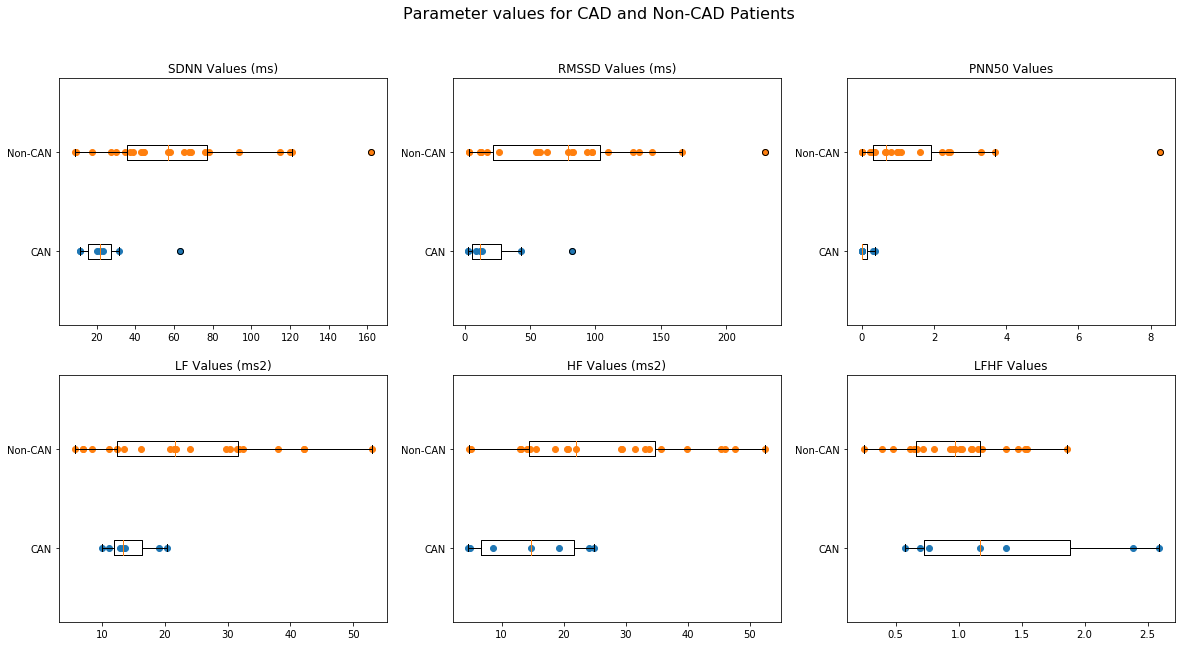

In [13]:
fig, axs = plt.subplots(2,3, figsize=(20,10))

fig.suptitle('Parameter values for CAD and Non-CAD Patients', fontsize=16)

lst = [1] * len(CAN_df['RMSSD'])
lst2 = [2] * len(nCAN_df['RMSSD'])

groups = ('CAN', 'Non-CAN')

axs[0, 0].scatter(CAN_df['SDNN'], lst)
axs[0, 0].scatter(nCAN_df['SDNN'], lst2)
axs[0, 0].boxplot([CAN_df['SDNN'], nCAN_df['SDNN']], vert = False)
axs[0,0].set_ylim([0.25, 2.75])
axs[0,0].set_yticks((1,2))
axs[0,0].set_yticklabels(groups)
axs[0,0].set_title('SDNN Values (ms)')

axs[0, 1].scatter(CAN_df['RMSSD'], lst)
axs[0, 1].scatter(nCAN_df['RMSSD'], lst2)
axs[0, 1].boxplot([CAN_df['RMSSD'], nCAN_df['RMSSD']], vert = False)
axs[0,1].set_ylim([0.25, 2.75])
axs[0,1].set_yticks((1,2))
axs[0,1].set_yticklabels(groups)
axs[0,1].set_title('RMSSD Values (ms)')

axs[0, 2].scatter(CAN_df['PNN50'], lst)
axs[0, 2].scatter(nCAN_df['PNN50'], lst2)
axs[0, 2].boxplot([CAN_df['PNN50'], nCAN_df['PNN50']], vert = False)
axs[0,2].set_ylim([0.25, 2.75])
axs[0,2].set_yticks((1,2))
axs[0,2].set_yticklabels(groups)
axs[0,2].set_title('PNN50 Values')

axs[1, 0].scatter(CAN_df['LF'], lst)
axs[1, 0].scatter(nCAN_df['LF'], lst2)
axs[1, 0].boxplot([CAN_df['LF'], nCAN_df['LF']], vert = False)
axs[1,0].set_ylim([0.25, 2.75])
axs[1,0].set_yticks((1,2))
axs[1,0].set_yticklabels(groups)
axs[1,0].set_title('LF Values (ms2)')

axs[1, 1].scatter(CAN_df['HF'], lst)
axs[1, 1].scatter(nCAN_df['HF'], lst2)
axs[1, 1].boxplot([CAN_df['HF'], nCAN_df['HF']], vert = False)
axs[1,1].set_ylim([0.25, 2.75])
axs[1,1].set_yticks((1,2))
axs[1,1].set_yticklabels(groups)
axs[1,1].set_title('HF Values (ms2)')

axs[1,2].scatter(CAN_df['LFHF'], lst)
axs[1,2].scatter(nCAN_df['LFHF'], lst2)
axs[1,2].boxplot([CAN_df['LFHF'], nCAN_df['LFHF']], vert = False)
axs[1,2].set_ylim([0.25, 2.75])
axs[1,2].set_yticks((1,2))
axs[1,2].set_yticklabels(groups)
axs[1,2].set_title('LFHF Values')
plt.show()

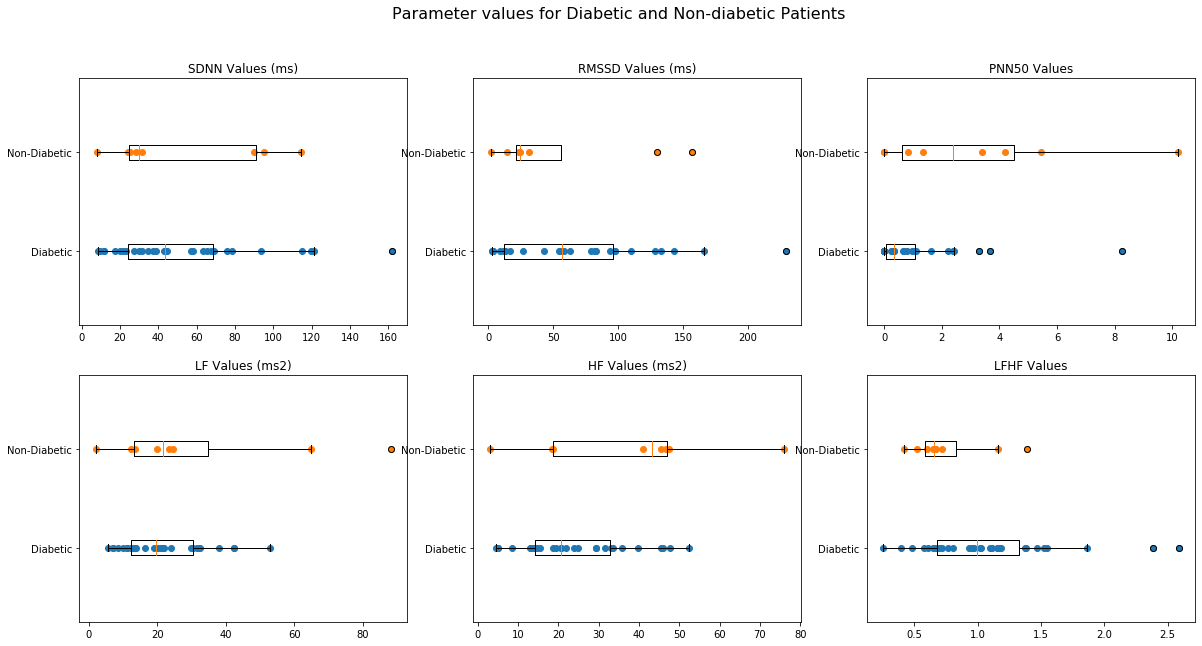

In [14]:
fig, axs = plt.subplots(2,3, figsize=(20,10))

fig.suptitle('Parameter values for Diabetic and Non-diabetic Patients', fontsize=16)

lst = [1] * len(DM_df['RMSSD'])
lst2 = [2] * len(Control_df['RMSSD'])

groups = ('Diabetic', 'Non-Diabetic')

axs[0, 0].scatter(DM_df['SDNN'], lst)
axs[0, 0].scatter(Control_df['SDNN'], lst2)
axs[0, 0].boxplot([DM_df['SDNN'], Control_df['SDNN']], vert = False)
axs[0,0].set_ylim([0.25, 2.75])
axs[0,0].set_yticks((1,2))
axs[0,0].set_yticklabels(groups)
axs[0,0].set_title('SDNN Values (ms)')

axs[0, 1].scatter(DM_df['RMSSD'], lst)
axs[0, 1].scatter(Control_df['RMSSD'], lst2)
axs[0, 1].boxplot([DM_df['RMSSD'], Control_df['RMSSD']], vert = False)
axs[0,1].set_ylim([0.25, 2.75])
axs[0,1].set_yticks((1,2))
axs[0,1].set_yticklabels(groups)
axs[0,1].set_title('RMSSD Values (ms)')

axs[0, 2].scatter(DM_df['PNN50'], lst)
axs[0, 2].scatter(Control_df['PNN50'], lst2)
axs[0, 2].boxplot([DM_df['PNN50'], Control_df['PNN50']], vert = False)
axs[0,2].set_ylim([0.25, 2.75])
axs[0,2].set_yticks((1,2))
axs[0,2].set_yticklabels(groups)
axs[0,2].set_title('PNN50 Values')

axs[1, 0].scatter(DM_df['LF'], lst)
axs[1, 0].scatter(Control_df['LF'], lst2)
axs[1, 0].boxplot([DM_df['LF'], Control_df['LF']], vert = False)
axs[1,0].set_ylim([0.25, 2.75])
axs[1,0].set_yticks((1,2))
axs[1,0].set_yticklabels(groups)
axs[1,0].set_title('LF Values (ms2)')

axs[1, 1].scatter(DM_df['HF'], lst)
axs[1, 1].scatter(Control_df['HF'], lst2)
axs[1, 1].boxplot([DM_df['HF'], Control_df['HF']], vert = False)
axs[1,1].set_ylim([0.25, 2.75])
axs[1,1].set_yticks((1,2))
axs[1,1].set_yticklabels(groups)
axs[1,1].set_title('HF Values (ms2)')

axs[1,2].scatter(DM_df['LFHF'], lst)
axs[1,2].scatter(Control_df['LFHF'], lst2)
axs[1,2].boxplot([DM_df['LFHF'], Control_df['LFHF']], vert = False)
axs[1,2].set_ylim([0.25, 2.75])
axs[1,2].set_yticks((1,2))
axs[1,2].set_yticklabels(groups)
axs[1,2].set_title('LFHF Values')
plt.show()

## Stat test application
### Mann-Whitney Test
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

Nonparametric testing if there is a statistically significant difference in the distribution of the HRV Parameters in CAN/Diabetic patients vs Non-CAN/Control patients.

Null Hypothesis is that the distributions are the same.

In [15]:
def MannWhit(df1, df2, parameter):
    # First value retuned is the test statistic for the first array inputted
    _, p = mannwhitneyu(df1[parameter], df2[parameter])
    print("Probability that the difference in distributions for the ", parameter, " parameter is due to chance: ", p)


# # Or One-sided test where you check if the first is significantly less than the second (but gives the same/inverse result)
# _, p = mannwhitneyu(Control_df['RMSSD'], DM_df['RMSSD'], alternative="less")

### Chi squared Test
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html

Some points:
- Tests for independence!
- Total number of samples recommended to be greater than 13 otherwise may overreject

### Applying the tests

In [17]:
parameters = ['RMSSD', 'PNN50', 'SDNN', 'HF', 'LF', 'LFHF']
dfs = [(DM_df, Control_df), (CAN_df, nCAN_df)]

print("Looking at DM vs control patients")
for pair in dfs:
    for para in parameters:
        MannWhit(pair[0], pair[1], para)

    print("\n\n Looking at CAN vs non-CAN patients")
    

Looking at DM vs control patients
Probability that the difference in distributions for the  RMSSD  parameter is due to chance:  0.3534732019270848
Probability that the difference in distributions for the  PNN50  parameter is due to chance:  0.04645883700391394
Probability that the difference in distributions for the  SDNN  parameter is due to chance:  0.39414066042903106
Probability that the difference in distributions for the  HF  parameter is due to chance:  0.05966999725781898
Probability that the difference in distributions for the  LF  parameter is due to chance:  0.3144138463432654
Probability that the difference in distributions for the  LFHF  parameter is due to chance:  0.05554022068765295


 Looking at CAN vs non-CAN patients
Probability that the difference in distributions for the  RMSSD  parameter is due to chance:  0.00619686017582347
Probability that the difference in distributions for the  PNN50  parameter is due to chance:  0.0030055633016621334
Probability that the dif

## Visualisation
### Initial plotting of parameters

Diabetic is Blue, control is Orange


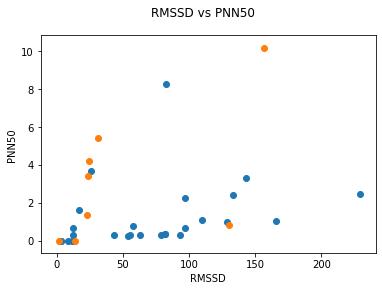

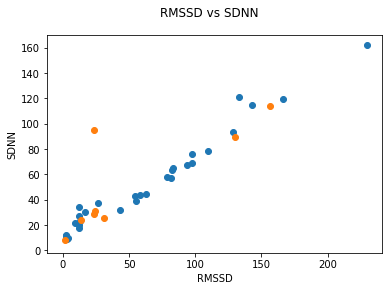

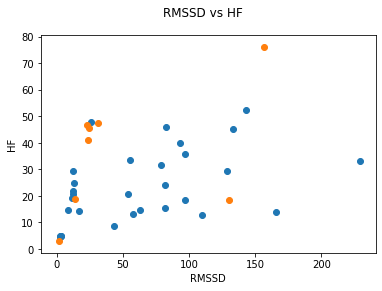

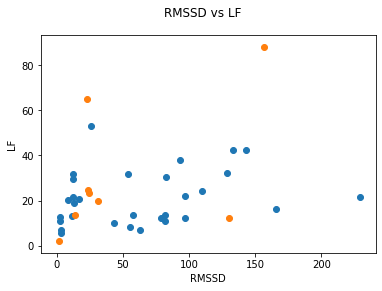

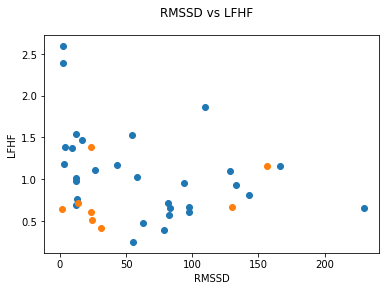

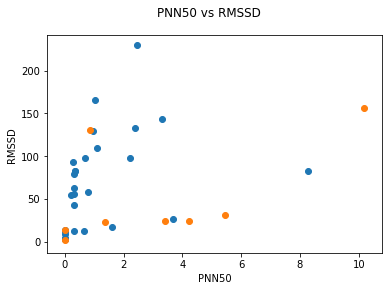

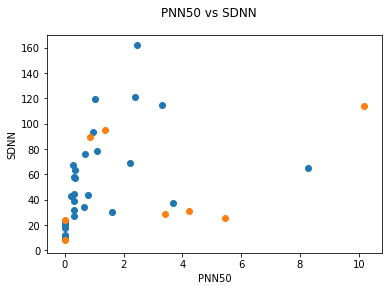

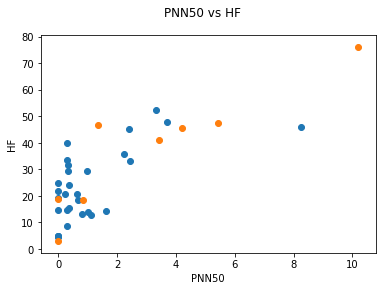

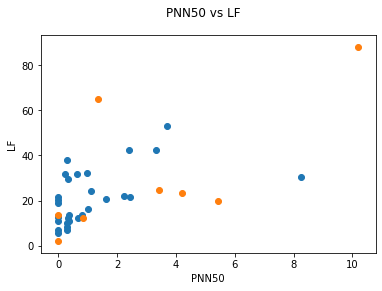

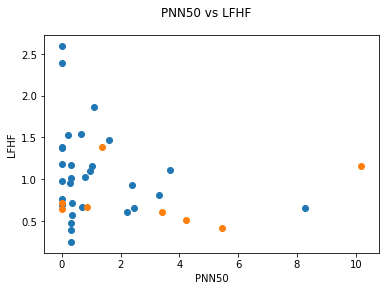

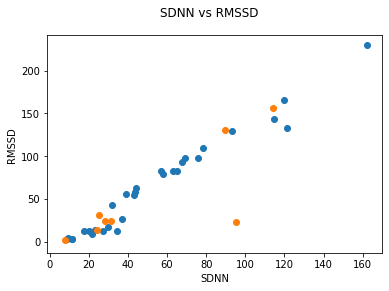

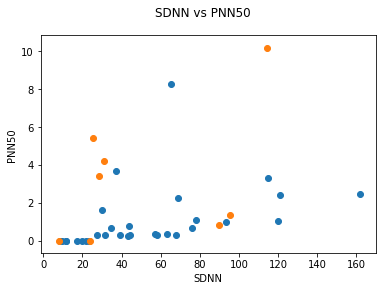

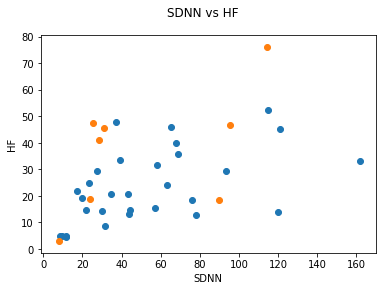

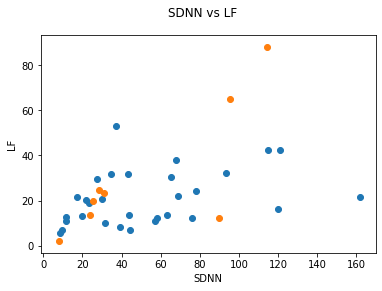

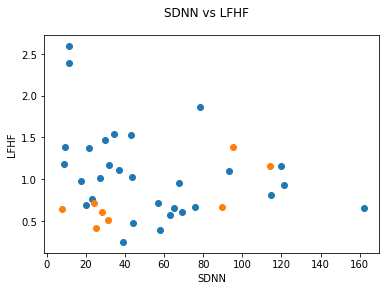

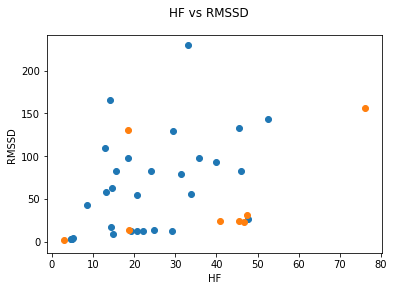

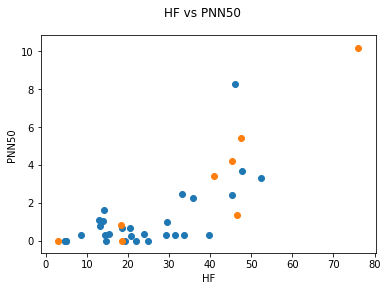

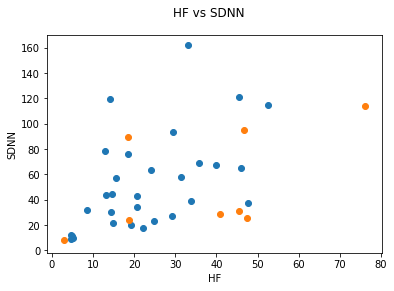

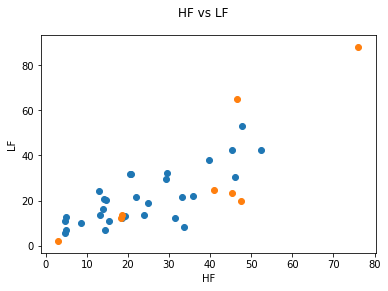

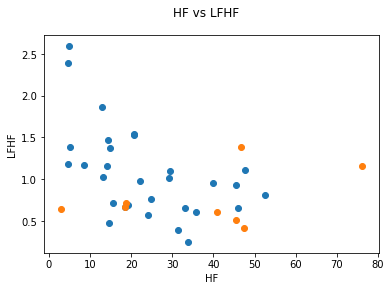

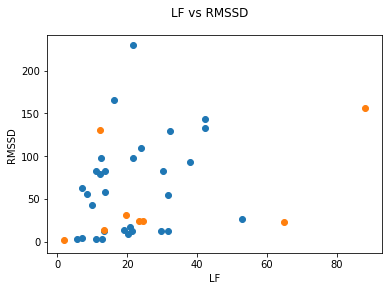

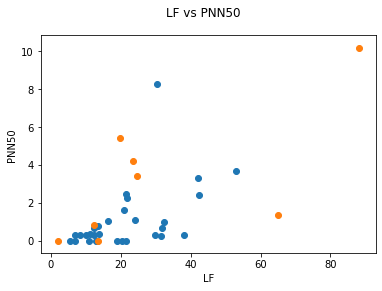

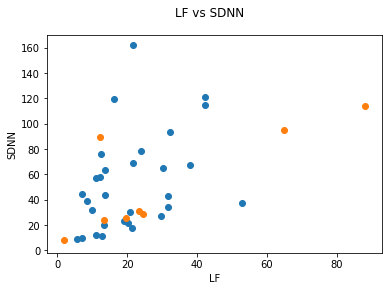

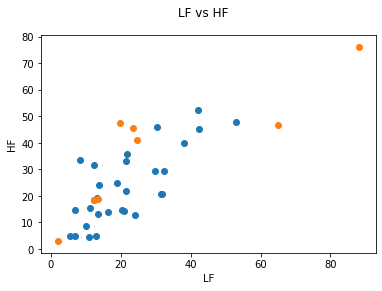

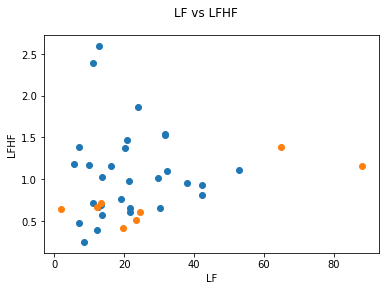

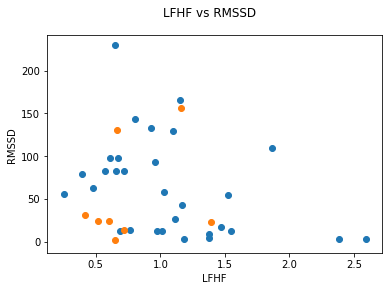

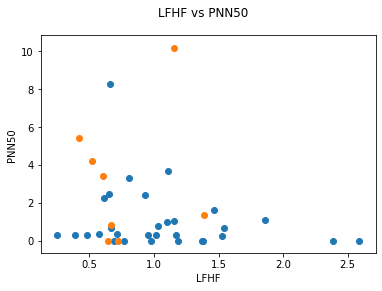

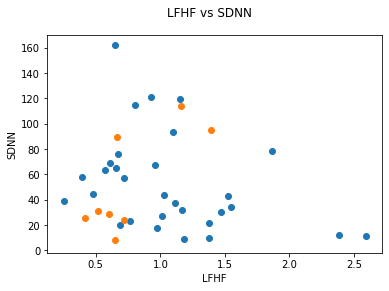

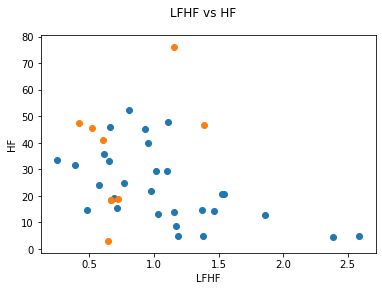

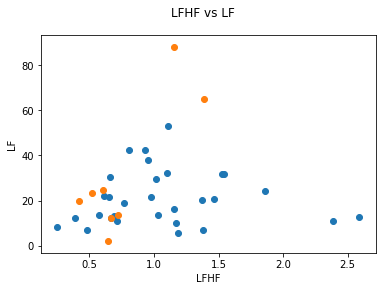

CAN is Blue, non-CAN is Orange


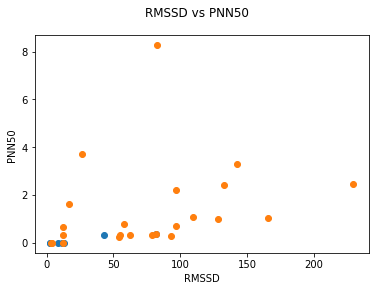

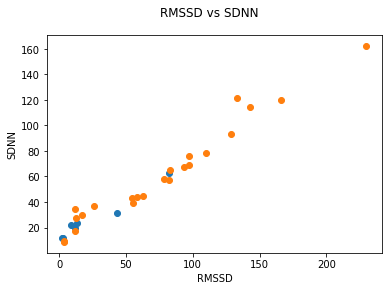

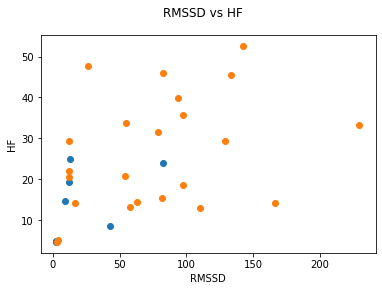

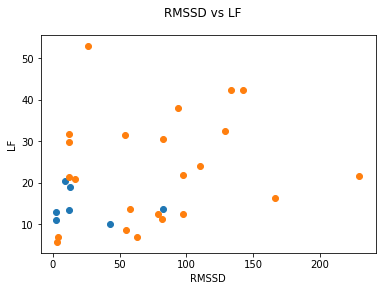

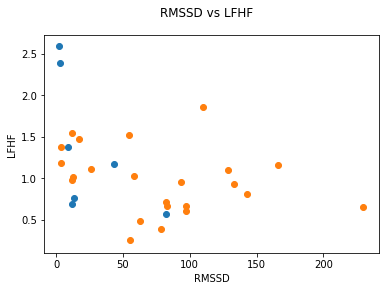

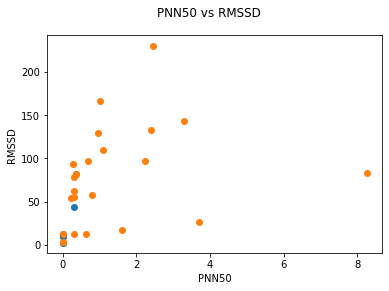

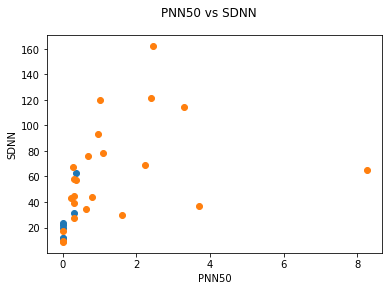

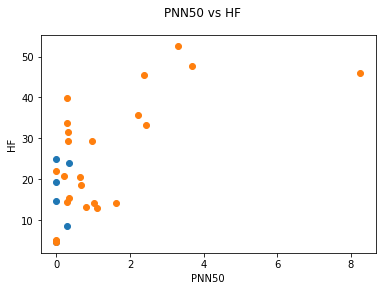

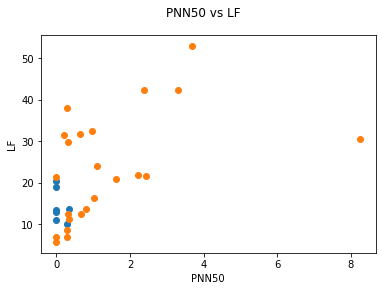

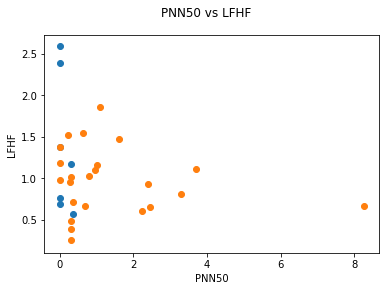

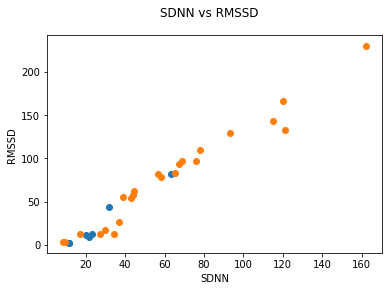

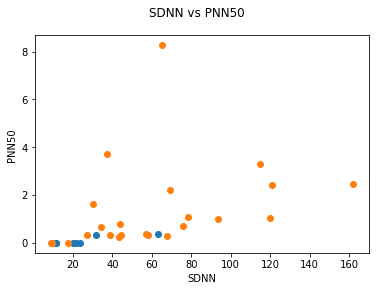

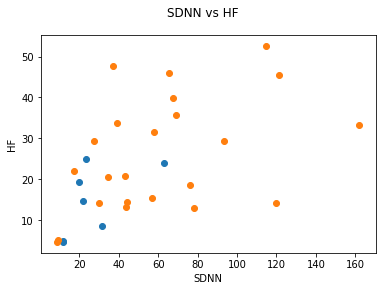

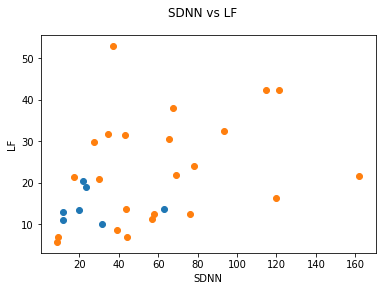

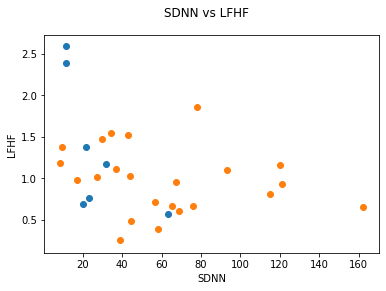

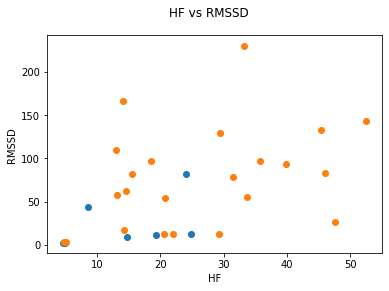

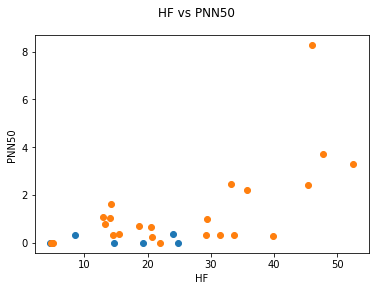

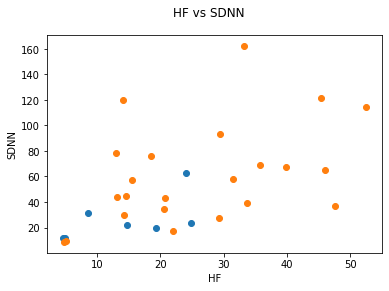

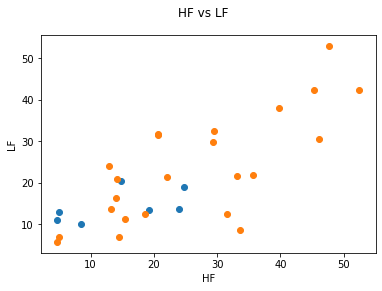

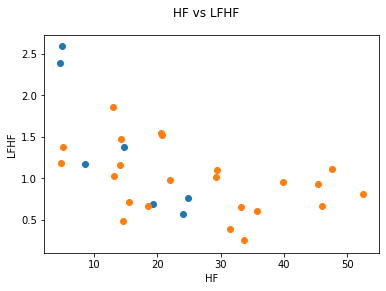

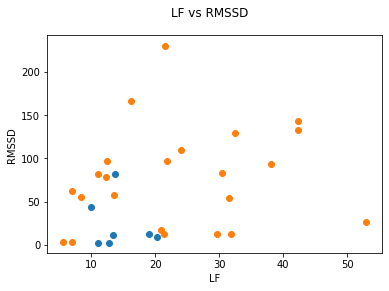

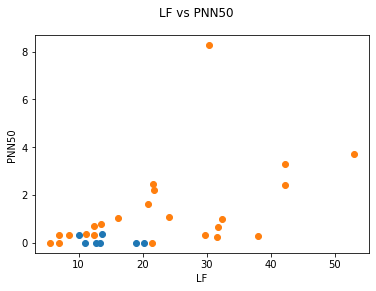

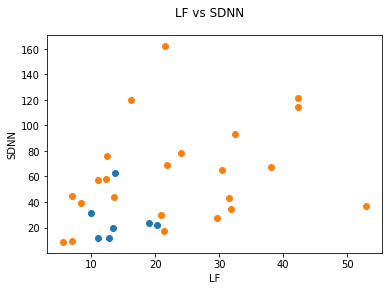

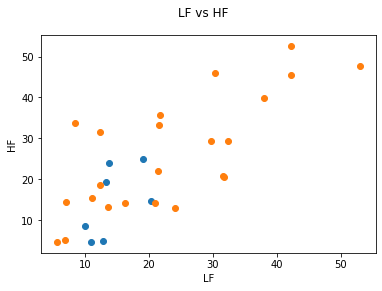

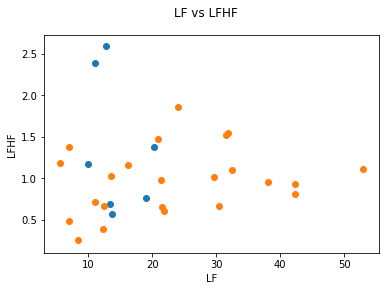

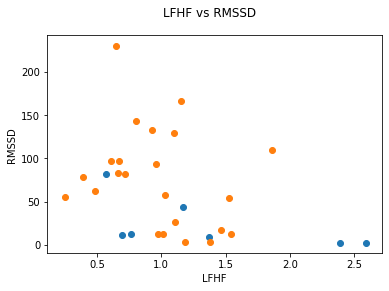

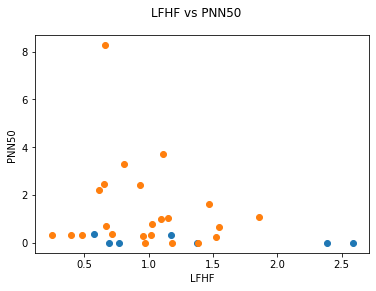

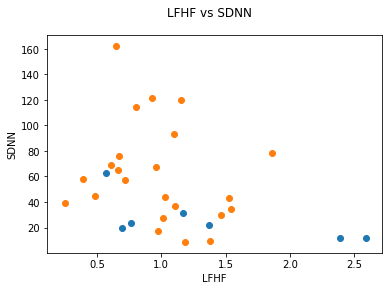

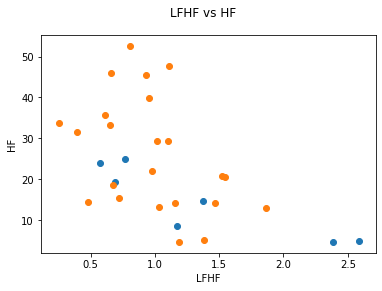

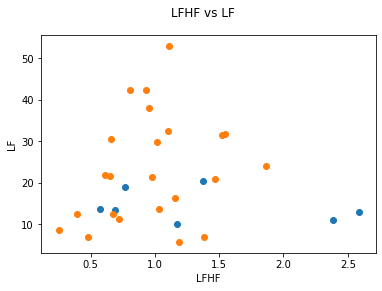

CAN is Blue, non-CAN is Orange


In [25]:
# Plotting parameters against each other in 2D
print('Diabetic is Blue, control is Orange')
for pair in dfs:
    for para in parameters:
        for par2 in list(filter(lambda x: x!= para, parameters)):
            fig = plt.figure()
            fig.suptitle((para +' vs '+ par2))
            plt.scatter(pair[0][para], pair[0][par2])
            plt.scatter(pair[1][para], pair[1][par2])
            plt.xlabel(para)
            plt.ylabel(par2)
            plt.show()
    print('CAN is Blue, non-CAN is Orange')

In [ ]:
# Plotting parameters against other patient variables